In [1]:
import numpy as np
import tensorflow as tf
# *으로 가져오는것은 권장하지 않습니다.
# Importing into * is not recommended.
from keras.layers import ZeroPadding2D, Conv2D,BatchNormalization,MaxPool2D, Dense, LeakyReLU, Add,\
GlobalAveragePooling2D,Softmax,DepthwiseConv2D,Reshape,Lambda,Concatenate,Input
from keras.losses import sparse_categorical_crossentropy, binary_crossentropy
from keras.models import Model
from keras.optimizers import Adam,Nadam
from keras import backend as K
from keras.utils.vis_utils import plot_model

Using TensorFlow backend.


ResNext의 구조는 ResNet과 크게 다르지 않습니다.   
The structure of ResNext is not much different from ResNet.

입력 부분은 ResNet과 같고, ConvNet Block에 중간에 ConvNet은 Group ConvNet을 사용합니다.  
The input part is the same as ResNet, and ConvNet uses Group ConvNet in the middle of ConvNet Block.

그리고 ResNet보다 두 배 많은 필터를 사용하고 두번째 ConvNet에 Stride를 적용해 1/2 크기로 줄입니다
And use twice as many filters as ResNet, Apply the stride to the 2nd ConvNet(ResNet:1st ConvNet) and reduce it to 1/2 size.

![image/depthwise.png](image/resnet_resnext.png)

In [2]:
def InputBlock(input_tensor):
    conv1_padding = ZeroPadding2D((3,3))(input_tensor)
    conv1_conv = Conv2D(64,7,strides=(2,2))(conv1_padding)
    conv1_bn = BatchNormalization()(conv1_conv)
    # 여기서는  ReLU 대신 LeakyReLU으로 구현해 봅니다.
    # We will implement LeakyReLU instead of ReLU here.
    conv1_relu = LeakyReLU()(conv1_bn) 
    return conv1_relu

def PoolingLayer(x):
    pool1_padding = ZeroPadding2D()(x)
    pool1_pool = MaxPool2D((3,3),2)(pool1_padding)    
    return pool1_pool

![image/depthwise.png](image/Grouped.png)

ResNeXt 논문에 구현된 중간 ConvNet을 보면 Grouped Conv를 사용한것으로 보입니다.  
look at the intermediate ConvNet implemented in the ResNeXt paper, it looks like you used Grouped Conv.

해당 ConvNet을 구현해보면 다음과 같습니다.

In [3]:
def GroupedConv(x):
    x_shape = int(x.shape[-1])
    print(x_shape)
    print(x.shape)

    C = x_shape // 32
    groups = []
    for i in range(32):
#         y= Lambda(lambda z :z[:,:,:,i*C:(i+1)*C])(x)
        y= Lambda(lambda z :z[:,:,:,i*C:(i+1)*C])(x)

        y = Conv2D(C,3,padding='same')(y)
        groups.append(y)
        
    x =Concatenate(axis=-1)(groups)
    
    return x


하지만 이와같은 방식은 매우 많은 연산시간을 필요로 합니다.  
But it takes a lot of computational time.

Keras에서 현재 Grouped ConvNet 함수는 없습니다.  
There is no Grouped ConvNet function in Keras.  

그에 대한 대안으로 Depthwise Separable Convolution에서 사용되는 DepthwiseConv를 사용해봅니다.  
Try DepthwiseConv as an alternative. DepthwiseConv is used by Depthwise Segmentation

Depthwise Separable Convolution는 Xception(https://arxiv.org/abs/1610.02357) 모델에서 제안된 방법입니다.  
Depthwise Separable Convolution is a proposed method on Xception(https://arxiv.org/abs/1610.02357) model.

![image/depthwise.png](image/Depthwise_Separable_Convolutions.png)

입력으로부터 분할해 n개의 ConvNet층을 사용하는 모습이 Grouped ConvNet과 유사해 보입니다.  
It looks similar to Grouped ConvNet by dividing from the input and using n ConvNet layers.  

이 방법을 사용해 구현해보도록 합니다.  
try to implement it this way.

In [4]:
def DepthwiseConv(x,stride=1, cardinality= 32):
    x_filter = int(x.shape[-1])

    C = x_filter // cardinality

    x = DepthwiseConv2D(1,strides=stride, depth_multiplier=C)(x)
    x_shape = K.int_shape(x)[1:-1] 
    # Reshap를 사용하여 (width, height, filter , count) 모양으로 바꾸어줍니다
    x = Reshape(x_shape + (cardinality, C, C))(x) 
    # 분리한 레이어를 하나로 더합니다.
    x = Lambda(lambda x: sum([x[:, :, :, :, i] for i in range(C)]))(x)

    x = Reshape((x_shape[0],x_shape[1],x_filter))(x) 

    return x

In [5]:
# x:  입력 레이어를 입력합니다..
# filters: ConvNet의 필터 갯수를 리스트로 입력합니다
#           example : 64,64,256 => [ 64,64,256 ]
# kernel_size: 커널 크기를 리스트 형태로 입력합니다 
#           example 1x1, 3x3, 1x1 => [ 1,3,1]
# block_count: 반복할 횟수를 지정합니다 1번 반복 후  Residual을 합니다.
# first_conv_strid (defult: True) : 첫번째 ConvNet의 stride를 2x2 크기로 주어 입력 크기를 감소시킵니다 
def ResidualBlock(x, filters, kernel_size, block_count,group=32,first_conv_strid = True):
    if(len(filters) != len(kernel_size)) :
        raise ValueError("filters count and kernel_size count must be the same(Filter:%d, Kernal: %d)"%(len(filters), len(kernel_size)))
    if (len(kernel_size)==0 or len(filters)==0):
        raise ValueError("Have not entered value")
    
    shortcut = x
    residual_conv= True #첫번째 residual에 ConvNet을 추가합니다
    for i in range(block_count):
        if residual_conv == True:            
            if first_conv_strid:
                shortcut = Conv2D(filters[-1],kernel_size[-1],strides=2,padding='same')(shortcut)
            else:
                shortcut = Conv2D(filters[-1],kernel_size[-1])(shortcut)
            shortcut = BatchNormalization()(shortcut)
            residual_conv = False
               
        x = Conv2D(filters[0],kernel_size[0])(x)            
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
        
        if first_conv_strid:
            x = DepthwiseConv(x,stride=2)
            first_conv_strid = False
        else:
            x = DepthwiseConv(x)
                
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
        
        if len(filters)==3:
            x = Conv2D(filters[2],kernel_size[2])(x)
            x = BatchNormalization()(x)
        x = Add()([x,shortcut])
        x = LeakyReLU()(x)
        shortcut = x
    return x

In [6]:
K.clear_session() 
def ResNeXt50(input_size):   
    inputs =  Input(shape=input_size)    
    conv1 = InputBlock(inputs)
    pooling = PoolingLayer(conv1)
    conv2 = ResidualBlock(pooling,filters=[128,128,256], kernel_size=[1,3,1], block_count=3,first_conv_strid=False)
    conv3 = ResidualBlock(conv2,filters=[256,256,512], kernel_size=[1,3,1], block_count=4)
    conv4 = ResidualBlock(conv3,filters=[512,512,1024], kernel_size=[1,3,1], block_count=6)
    conv5 = ResidualBlock(conv4,filters=[1024,1024,2048], kernel_size=[1,3,1], block_count=3)
 
    model =  Model(inputs, conv5)
    return model
model = ResNeXt50((224,224,3))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 112, 112, 64) 9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 112, 112, 64) 256         conv2d_1[0][0]                   
____________________

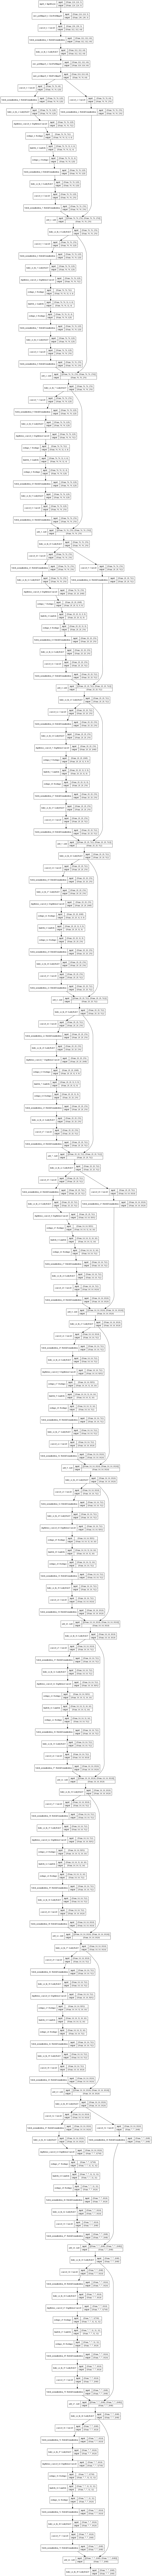

In [7]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)